In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from plotnine import ggplot, geom_point, geom_line, aes, ylim, facet_wrap, theme_classic, ylab, xlab, geom_bar, facet_grid, geom_errorbar

plt.rcParams['font.sans-serif'] = 'Arial'

# Figure 2: Plot empirical data trends

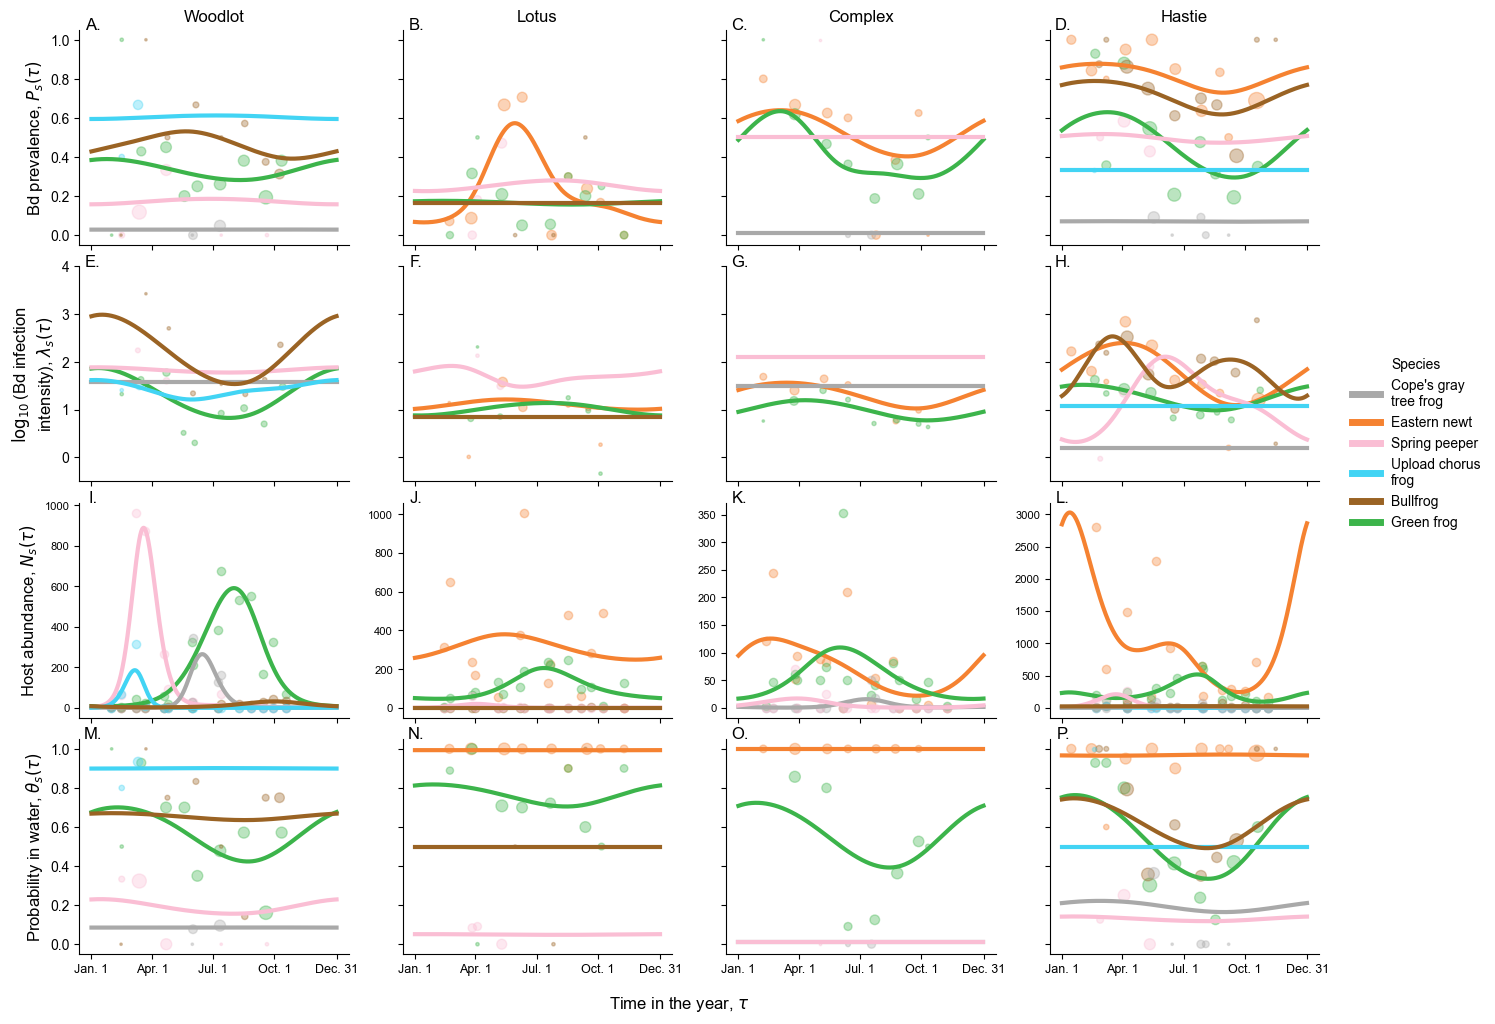

In [19]:
surface_area = True
microhabitat = True
constant_density = False
constant_intensity = False
constant_water = False
constant_prev = False
sites = [2, 7, 10, 15]
site_map = {2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"}
data_keys = ['prev', 'intensity', 'density', 'water']
obs_keys = ['bd_pos', 'load', 'count', 'water']
pretty_keys = [r'Bd prevalence, $P_s(\tau)$', 
               "$\log_{10}$(Bd infection\nintensity), " + r"$\lambda_s(\tau)$", 
               r"Host abundance, $N_s(\tau)$", 
               r"Probability in water, $\theta_s(\tau)$"]
fig, axes = plt.subplots(4, len(sites), figsize=(16, 12), sharex=True)

pond_areas = {2: 964,
              7: 3141,
              10 : 93,
              15 : 4687}

ylims = [(-0.05, 1.05), (-0.5, 4), None, (-0.05, 1.05)]

# Colors of different species
colors = {'novi': "#f58231", 
          'pscr': "#fabed4", 
          'hych': "#a9a9a9", 
          'psfe': "#42d4f4",
          'raca': "#9A6324",
          "racl": "#3cb44b"}

spp_map = {'hych': "Cope's gray\ntree frog", 
           'pscr': "Spring peeper", 
           "raca": "Bullfrog", 
           "racl": "Green frog",
           "psfe": "Upload chorus\nfrog",
           "novi": "Eastern newt"}

for j, site_num in enumerate(sites):
    
    pred_values = pd.read_pickle("../results/all_values_{0}_results_microhabitat={1}_surface_area={2}_constant_density={3}_constant_water={4}_constant_intensity={5}_constant_prev={6}.pkl".format(site_num, microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev))

    for i, key in enumerate(data_keys):
        
        species = pred_values['species']
        
        obs_values = pd.read_pickle("../results/all_fitting_info_{0}_{1}.pkl".format(site_num, obs_keys[i]))
        
        for s, spp in enumerate(species):

            # Plot predicted values
            # axes[i, j].plot(pred_values['time_steps'], pred_values[key][s, :], color=colors[spp], lw=3, zorder=10 if spp == 'raca' else 1)
            
            # Plot observed values
            if obs_values[spp]['x'] is not None:
                
                if key != 'density':
                    df = pd.DataFrame({'x': np.floor(obs_values[spp]['x'].ravel()).astype(np.int64), 'y': obs_values[spp]['y'].ravel()})
                    df['month'] = pd.to_datetime("2022-" + df.x.astype(np.str_), format="%Y-%j").dt.month
                    grouped_df = df.groupby('month').agg({'y': 'mean', 'x': (np.mean, len)})
                    grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]

                    axes[i, j].scatter(grouped_df.x_mean, grouped_df.y_mean, s=grouped_df.x_len*3, marker='o', color=colors[spp], zorder=-1, alpha=0.35)
                    minx = grouped_df.x_mean.min()
                    maxx = grouped_df.x_mean.max()
                else:
                    axes[i, j].scatter(obs_values[spp]['x'].ravel(), obs_values[spp]['y'], marker='o', color=colors[spp], zorder=-1, alpha=0.35)
                    minx = obs_values[spp]['x'].ravel().min()
                    maxx = obs_values[spp]['x'].ravel().max()
                    
                    
            # Plot predicted values
            axes[i, j].plot(pred_values['time_steps'], pred_values[key][s, :], color=colors[spp], lw=3, zorder=10 if spp == 'raca' else 1)
            
            # Just minmax values
            #ind = pd.Series((pred_values['time_steps'] >= minx)) & pd.Series((pred_values['time_steps'] <= maxx))
            #ind = ind.values
            #axes[i, j].plot(pred_values['time_steps'][ind], pred_values[key][s, :][ind], color=colors[spp], lw=3, zorder=10 if spp == 'raca' else 1)
            

        if ylims[i] is not None:
            axes[i, j].set_ylim(ylims[i])
        
        axes[i, j].spines['right'].set_visible(None)
        axes[i, j].spines['top'].set_visible(None)

# Loop over columns for formatting
for i in range(len(pretty_keys)):
    for j, ax in enumerate(axes[i, :]):
        
        if j == 0:
            ax.set_ylabel(pretty_keys[i], size=12)
            if i == 2:
                ax.tick_params(axis='y', labelsize=8)
        else:
            if i != 2:
                ax.tick_params(axis='y', labelleft=None)
            else:
                ax.tick_params(axis='y', labelsize=8)

# Format x-axis
for j in range(len(sites)):                
    axes[3, j].set_xticks([1, 91, 182, 273, 366])
    axes[3, j].set_xticklabels(["Jan. 1", 'Apr. 1', 'Jul. 1', 'Oct. 1', 'Dec. 31'], size=9)
    
fig.supxlabel(r"Time in the year, $\tau$", y=0.06)

# Format title
for j in range(len(sites)):
    axes[0, j].set_title(site_map[sites[j]])
    
fig.subplots_adjust(hspace=0.1)

# Add a legend
ordered_spp = np.sort(list(colors.keys()))
handles = [plt.Line2D([0], [0], color=colors[s], lw=5, label=spp_map[s]) for s in ordered_spp]
axes[1, 3].legend(handles=handles, loc=(1.1, -0.25), frameon=False, title="Species")

# Add letters to all plots
letters = list(string.ascii_uppercase)
count = 0
for i in range(4):
    for j in range(4):
        axes[i, j].text(0.05, 1, letters[count] + ".", size=12, ha="center", transform=axes[i, j].transAxes)
        count = count + 1
    
plt.show()
fig.savefig("../results/empirical_patterns_across_sites.pdf", bbox_inches="tight")

## Figure S1: Surface area plots

In [196]:
full_dat = pd.read_csv("../data/all_field_samples.csv")
full_dat = full_dat[['date', 'species', 'svl_mm', 'weight_of_animal_bag_g', 
                     'weight_of_bag', 'site_id', 'doy', 'bd_positive', 
                     'bd_load', 'microhabitat', 'site_name']]
full_dat['date'] = pd.to_datetime(full_dat.date) 
full_dat['mass_g'] = full_dat.weight_of_animal_bag_g - full_dat.weight_of_bag
common_names = {'novi': 'Eastern newt', 'pscr': 'Spring peeper', 
                'hych': "Cope's gray tree frog", 'psfe': 'Upland chorus frog',
                'raca': 'Bullfrog', 'racl': 'Green frog'}

# Drop one clear measurement error
full_dat = full_dat.query("bd_load < 1e7")

keep_sites = np.array([2, 7, 10, 15])
species_list = {2: ['racl', 'pscr', 'raca', 'hych', 'psfe'],
                7: ['novi', 'racl', 'raca', 'pscr'],
                10: ['novi', 'racl', 'hych', 'pscr'],
                15: ['novi', 'racl', 'raca', 'pscr', 'psfe', 'hych']}

red_dat = full_dat[full_dat.site_id.isin(keep_sites)]
anurans = ['racl', 'rapa', 'pscr', 'psfe', 'gaca', 'rasy', 'hych', 'raca']
caudates = ['novi', 'amma']
red_dat['surface_area'] = [13.1826*red_dat.mass_g.values[i]**0.6091 if spp in anurans else 8.42*red_dat.mass_g.values[i]**0.694 for i, spp in enumerate(red_dat.species.values)]
red_dat = red_dat[red_dat.species.isin(['racl', 'raca', 'psfe', 'pscr', 'novi', 'hych'])]

mean_sa = red_dat.groupby(['site_id', 'species']).agg({'surface_area': (np.mean, lambda x: np.std(x) / np.sqrt(len(x)), len)})
mean_sa.columns = ['mean_sa', 'se_sa', 'n_sa']
mean_sa = mean_sa.reset_index()
mean_sa['n_sa'] = mean_sa.n_sa.astype(np.str_)

/var/folders/4k/1wymgyj119ldyv4w2nc7py400000gn/T/ipykernel_49540/3290937247.py:23: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/4k/1wymgyj119ldyv4w2nc7py400000gn/T/ipykernel_49540/3290937247.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [197]:
from plotnine import geom_bar, position_dodge2, scale_fill_manual, geom_errorbar, position_dodge, geom_text, labs

names_ordered = ["Cope's gray tree frog", 'Eastern newt', 'Spring peeper', 
                 'Upland chorus frog', 'Bullfrog', 'Green frog']
mean_sa['site'] = mean_sa.site_id.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})
mean_sa['lower_sa'] = mean_sa.mean_sa.values - mean_sa.se_sa.values
mean_sa['upper_sa'] = mean_sa.mean_sa.values + mean_sa.se_sa.values
mean_sa['site'] = pd.Categorical(mean_sa['site'], categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])
mean_sa['species_pretty'] = mean_sa.species.map(common_names)
mean_sa['species_pretty'] = pd.Categorical(mean_sa.species_pretty, categories=names_ordered)

/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4.5 in image.
/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../results/surface_areas.pdf


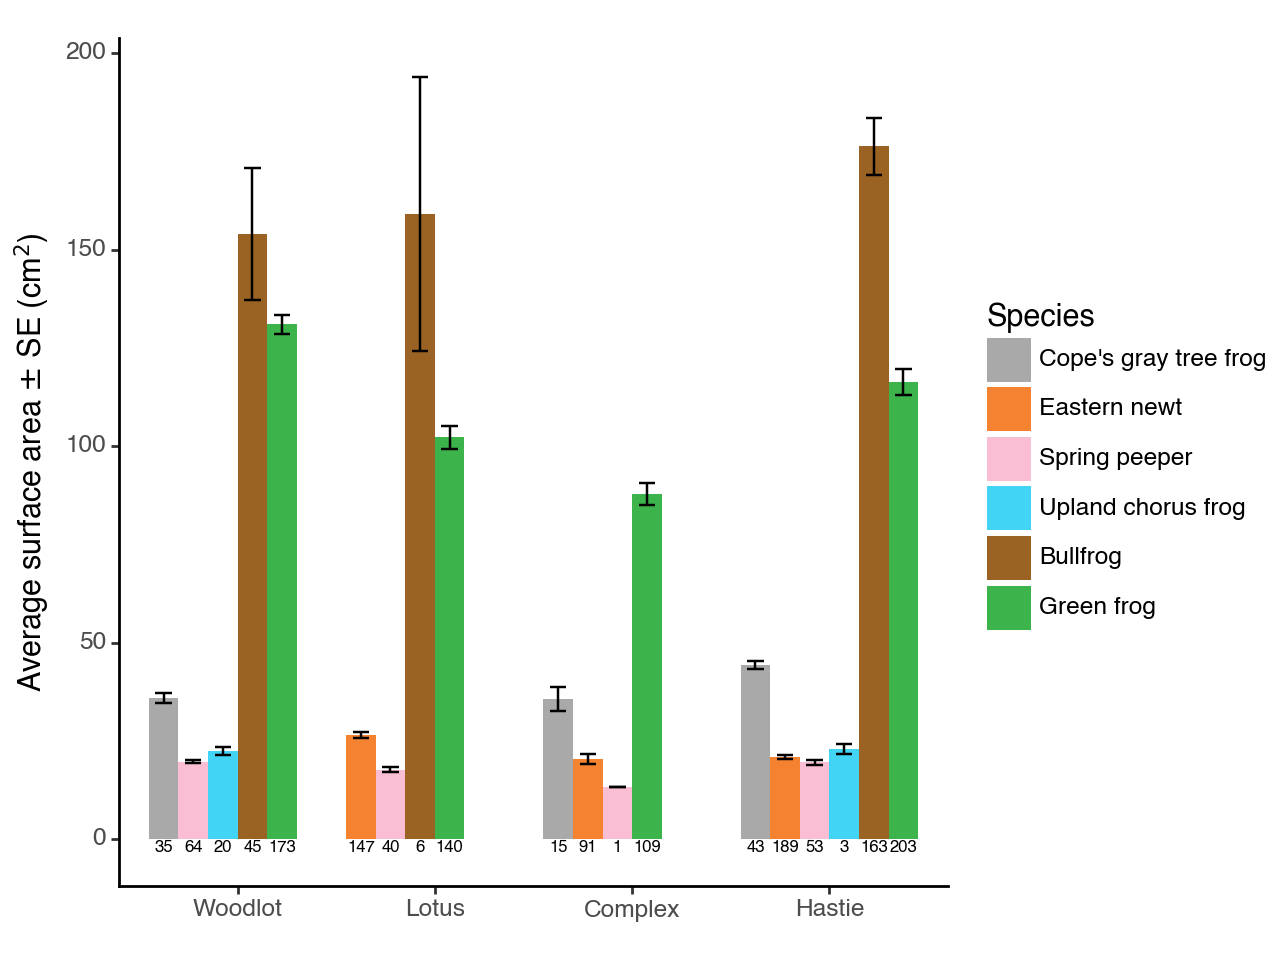

<Figure Size: (640 x 480)>

In [198]:
p = (ggplot(mean_sa) + geom_bar(aes(x="site", y="mean_sa", fill="species_pretty"), stat="identity", position=position_dodge(width=0.9, preserve="single")) +
                   geom_errorbar(aes(x="site", ymin="lower_sa", ymax="upper_sa", group="species_pretty"), position=position_dodge(width=0.9, preserve="single")) +
                   geom_text(aes(x="site", y=-2, label="n_sa", group="species_pretty"), size=6,  position=position_dodge(width=0.9, preserve="single")) +
                  scale_fill_manual(values=[colors[s] for s in np.sort(list(colors.keys()))]) + 
                  theme_classic() + ylab("Average surface area $\pm$ SE (cm$^2$)") + xlab("") + labs(fill="Species"))

p.save("../results/surface_areas.pdf", width=6, height=4.5)
p

## Figure 3: Species-level $R_0$ patterns and ranks

In [5]:
surface_area = True
microhabitat = True
constant_density = False
constant_intensity = False
constant_water = False
constant_prev = False
omega = 1.0 # Degree of interspecific transmission relative to intraspecific transmisison
site_nums = [2, 7, 10, 15]
site_R0 = {}

# Extract the site-level R0s
for sn in site_nums:
    print(sn)
    R = pd.read_pickle("../results/R_matrix_site={0}_microhabitat={1}_surface_area={2}_constant_density={3}_constant_water={4}_constant_intensity={5}_constant_prev={6}_omega={7}.pkl".format(sn, microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))[0]
    R0 = np.max(np.abs(np.linalg.eigvals(R)))
    print(R0)
    site_R0[sn] = R0

2
1.6736526817919928
7
1.3258838791087946
10
2.0359264832955026
15
4.785962137353542


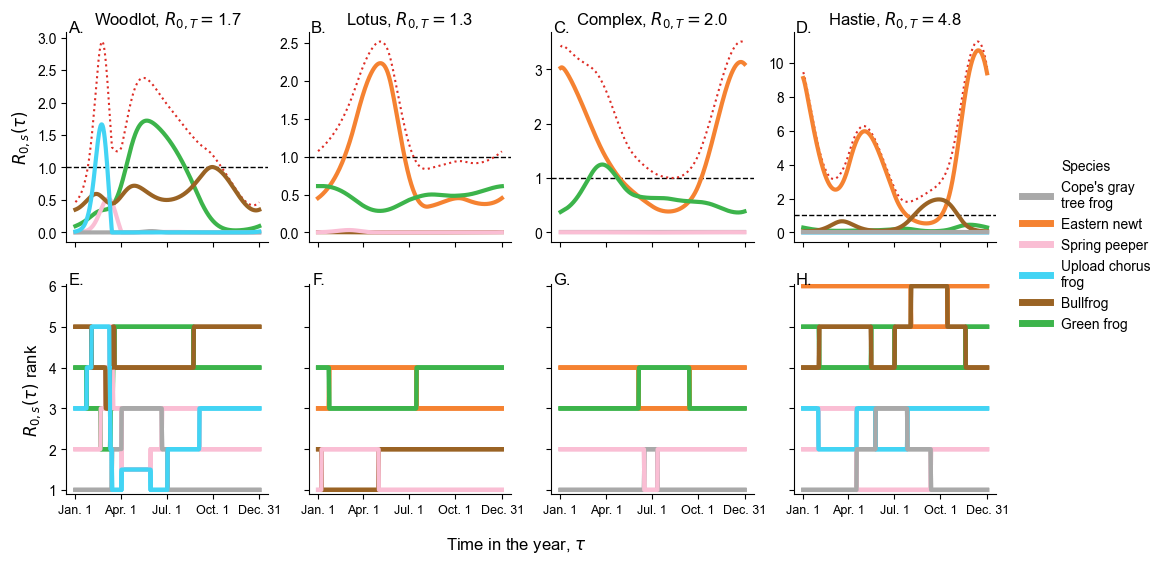

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)

omega = 1.0
R0vals = pd.read_csv("../results/all_R0s_microhabitat={0}_surface_area={1}_constant_density={2}_constant_water={3}_constant_intensity={4}_constant_prev={5}_omega={6}.csv".format(microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))

smap = {2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"}
smap_inv = {value : key for key, value in smap.items()}
R0vals['R0_rank'] = R0vals.groupby(['julian_date', 'site'])['R0'].rank(ascending=True)
R0vals['site_name'] = R0vals.site.map(smap)
R0vals['site_name'] = pd.Categorical(R0vals.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])
R0vals['R0_norm'] = R0vals.groupby(['site'])['R0'].transform(lambda x: x / x.max())

R0vals_grouped = (R0vals.groupby(["site", "julian_date"])
                        .agg({'R0': np.sum})
                        .reset_index())

spp_map = {'hych': "Cope's gray\ntree frog", 
           'pscr': "Spring peeper", 
           "raca": "Bullfrog", 
           "racl": "Green frog",
           "psfe": "Upload chorus\nfrog",
           "novi": "Eastern newt"}

totalR0s = {smap[k]: v for k, v in site_R0.items()}

# Plot R0_norm
sites = R0vals.site_name.unique()
for i, site in enumerate(sites):

    site_dat = R0vals.query(f"site_name == @site")

    species = site_dat.species.unique()

    # Plot the grouped R0
    gR0 = R0vals_grouped.query("site == {0}".format(smap_inv[site]))
    axes[0, i].plot(gR0.julian_date, gR0.R0, color='#de2d26', ls='dotted')

    for spp in species:

        spdat = site_dat.query(f"species == @spp")
        axes[0, i].plot(spdat.julian_date, spdat.R0, color=colors[spp], lw=3)

    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].spines['top'].set_visible(False)
    xlim = axes[0, i].get_xlim()
    axes[0, i].hlines(1, *xlim, color='black', linestyle='dashed', zorder=-1, lw=1)
    axes[0, i].set_xlim(*xlim)
    #axes[0, i].set_ylim(-0.05, 1.05)

    if i != 0:
        #axes[0, i].tick_params(axis='y', labelleft=None)
        pass
    else:
        axes[0, i].set_ylabel(r"$R_{0, s}(\tau)$", size=12)

    axes[0, i].set_title(site + r", $R_{0, T} =$" + "{0:.1f}".format(totalR0s[site]))

    # Plot R0_rank
    sites = R0vals.site_name.unique()
    for i, site in enumerate(sites):

        site_dat = R0vals.query(f"site_name == @site")

        species = site_dat.species.unique()

        for spp in species:

            spdat = site_dat.query(f"species == @spp")
            axes[1, i].plot(spdat.julian_date, spdat.R0_rank, color=colors[spp], lw=3)

        axes[1, i].spines['right'].set_visible(False)
        axes[1, i].spines['top'].set_visible(False)
        axes[1, i].set_ylim(.9, 6.05)

        if i != 0:
            axes[1, i].tick_params(axis='y', labelleft=None)
        else:
            axes[1, i].set_ylabel(r"$R_{0, s}(\tau)$ rank", size=12)

# Add a legend
ordered_spp = np.sort(list(colors.keys()))
handles = [plt.Line2D([0], [0], color=colors[s], lw=5, label=spp_map[s]) for s in ordered_spp]
axes[1, 3].legend(handles=handles, loc=(1.1, 0.75), frameon=False, title="Species")

# Format xlabels
for j in range(len(sites)):                
    axes[1, j].set_xticks([1, 91, 182, 273, 366])
    axes[1, j].set_xticklabels(["Jan. 1", 'Apr. 1', 'Jul. 1', 'Oct. 1', 'Dec. 31'], size=9)

fig.supxlabel(r"Time in the year, $\tau$")
#fig.supxlabel("Time (years)")

# Add letters to all plots
letters = list(string.ascii_uppercase)
count = 0
for i in range(2):
    for j in range(4):
        axes[i, j].text(0.05, 1, letters[count] + ".", size=12, ha="center", transform=axes[i, j].transAxes)
        count = count + 1

# Plot other omegas to compare

# omega_vals = [0.25]
# linewidths = [1]

# for h, omega in enumerate(omega_vals):
    
#     R0vals = pd.read_csv("../results/all_R0s_microhabitat={0}_surface_area={1}_constant_density={2}_constant_water={3}_constant_intensity={4}_constant_prev={5}_omega={6}.csv".format(microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))

#     R0vals['R0_rank'] = R0vals.groupby(['julian_date', 'site'])['R0'].rank(ascending=True)
#     R0vals['site_name'] = R0vals.site.map(smap)
#     R0vals['site_name'] = pd.Categorical(R0vals.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])
#     R0vals['R0_norm'] = R0vals.groupby(['site'])['R0'].transform(lambda x: x / x.max())

#     R0vals_grouped = (R0vals.groupby(["site", "julian_date"])
#                             .agg({'R0': np.sum})
#                             .reset_index())

#     # Plot R0_norm
#     sites = R0vals.site_name.unique()
#     for i, site in enumerate(sites):

#         site_dat = R0vals.query(f"site_name == @site")

#         species = site_dat.species.unique()

#         # Plot the grouped R0
#         gR0 = R0vals_grouped.query("site == {0}".format(smap_inv[site]))
#         #axes[0, i].plot(gR0.julian_date, gR0.R0, color='#de2d26', ls='dotted')

#         for spp in species:

#             spdat = site_dat.query(f"species == @spp")
#             axes[0, i].plot(spdat.julian_date, spdat.R0, color=colors[spp], lw=linewidths[h], alpha=0.25)


plt.show()
fig.savefig("../results/species_contributions_surfacearea={0}.pdf".format(surface_area), bbox_inches="tight")

In [205]:
# Look at amount of time as the top rank
R0vals['rank'] = R0vals.groupby(['julian_date', 'site'])['R0'].rank(ascending=False)
R0vals.groupby(['species', 'site']).agg({'rank': lambda x: np.mean(x == 1)}) 

rank
species site          
hych    2     0.000000
        10    0.000000
        15    0.000000
novi    7     0.474623
        10    0.725652
        15    0.802469
pscr    2     0.016461
        7     0.000000
        10    0.000000
        15    0.000000
psfe    2     0.097394
        15    0.000000
raca    2     0.454047
        7     0.000000
        15    0.197531
racl    2     0.432099
        7     0.525377
        10    0.274348
        15    0.000000

## Fig. 4:  Change in rank variance of $R_{0, s}(\tau)$

In [7]:
surface_area = True
microhabitat = True
constant_density = False
constant_intensity = False
constant_water = False
constant_prev = False
omega = 1.0
R0vals = pd.read_csv("../results/all_R0s_microhabitat={0}_surface_area={1}_constant_density={2}_constant_water={3}_constant_intensity={4}_constant_prev={5}_omega={6}.csv".format(microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))


R0vals['R0_rank'] = R0vals.groupby(['julian_date', 'site'])['R0'].rank(ascending=True)
R0vals['site_name'] = R0vals.site.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})
R0vals['site_name'] = pd.Categorical(R0vals.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])

# Get the variance in rank
baseline_var = (R0vals.groupby(["species", "site"])
                      .agg({'R0_rank': 'var'})
                      .reset_index().groupby(['site'])
                      .agg({'R0_rank': 'sum'}).reset_index()).set_index("site")

baseline_var

,R0_rank
site,
2,3.429335
7,0.928835
10,0.533728
15,2.291635


In [221]:
microhabitat = True
constant_density = False
constant_water = False
constant_intensity = True
constant_prev = False
surface_area = True
omega = 1.0

# Order: microhabitat, density, water, intensity, prevalence, surface_area
combos = {'Density': (True, True, False, False, False, True),
          'Space use': (True, False, True, False, False, True),
          'Intensity': (True, False, False, True, False, True),
          'Prevalence': (True, False, False, False, True, True)}

# combos = {'constant_intensity': (True, False, False, True, False, True),
#           'constant_density': (True, True, False, True, False, True)}

var_res = {}

for key, tfc in combos.items():

    microhabitat = tfc[0]
    constant_density = tfc[1]
    constant_water = tfc[2]
    constant_intensity = tfc[3]
    constant_prev = tfc[4]
    surface_area = tfc[5]


    R0vals = pd.read_csv("../results/all_R0s_microhabitat={0}_surface_area={1}_constant_density={2}_constant_water={3}_constant_intensity={4}_constant_prev={5}_omega={6}.csv".format(microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))


    R0vals['R0_rank'] = R0vals.groupby(['julian_date', 'site'])['R0'].rank(ascending=True)
    R0vals['site_name'] = R0vals.site.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})
    R0vals['site_name'] = pd.Categorical(R0vals.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])

    # Get the variance in rank
    up_var = (R0vals.groupby(["species", "site"])
                          .agg({'R0_rank': 'var'})
                          .reset_index().groupby(['site'])
                          .agg({'R0_rank': 'sum'}).reset_index()).set_index("site")

    var_res[key] = (up_var - baseline_var) / baseline_var

/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../results/sensitivity_analysis.pdf


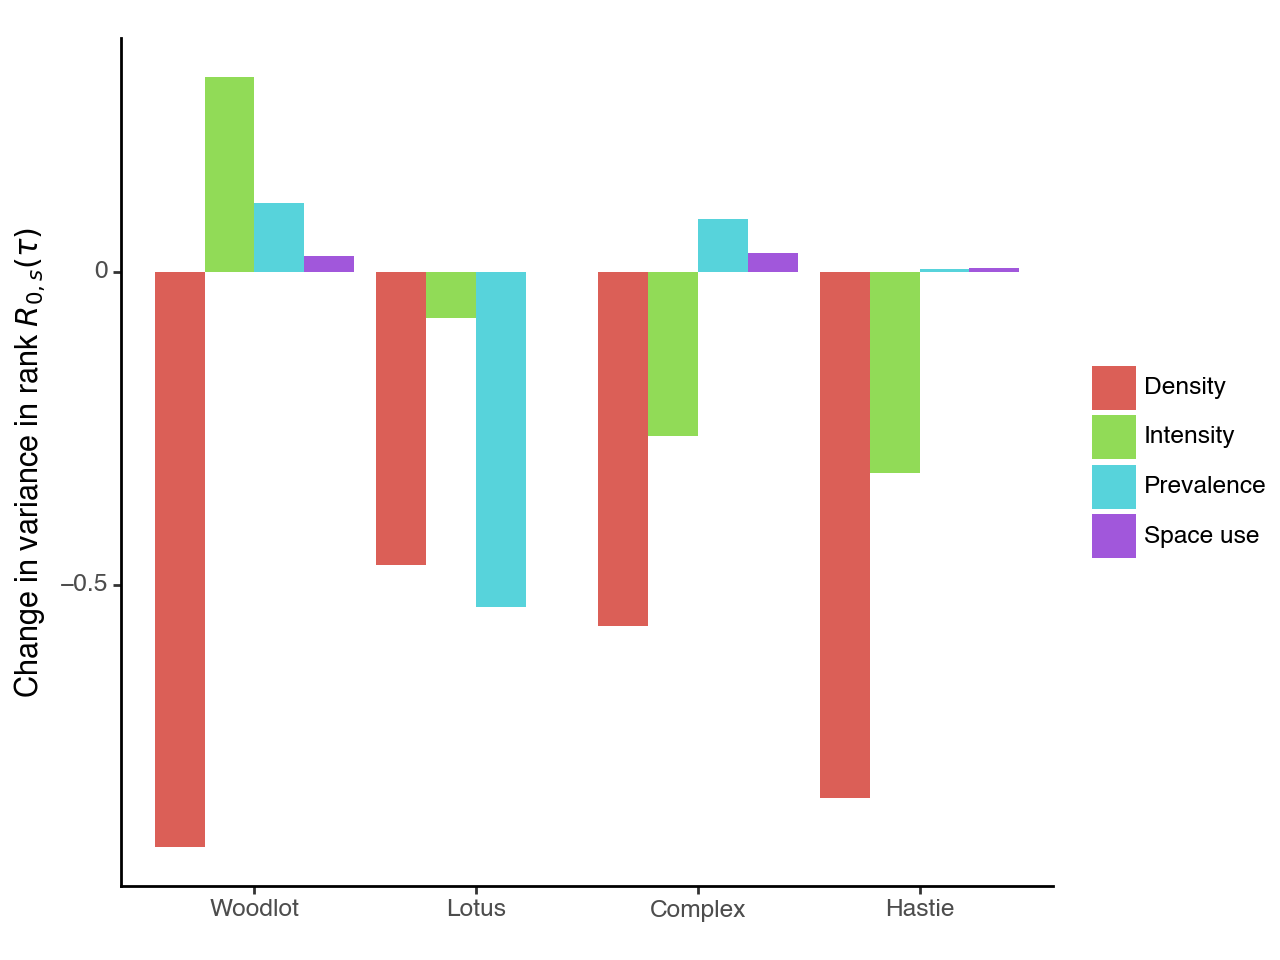

<Figure Size: (640 x 480)>

In [222]:
from plotnine import element_text, theme, element_blank
var_df = pd.concat(var_res).reset_index().rename(columns={'level_0': 'variable', 'R0_rank': "diff"})
var_df['site_name'] = var_df.site.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})

var_df['site_name'] = pd.Categorical(var_df.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])

g = (ggplot(var_df) + geom_bar(aes(x="site_name", y="diff", fill="variable"), stat="identity", position="dodge") + 
                  theme_classic() + ylab("Change in variance in rank $R_{0, s}(\\tau)$") + 
                  xlab("") + theme(legend_title=element_blank()))

g.save("../results/sensitivity_analysis.pdf", width=6, height=4)
g

# Q2:  Are species or temporal periods most important for driving Bd persistence in these sites? 

## Fig. 6: Just the species-level control part of Fig. 6

The code below performs species-level controls and temporal controls on four 3-month time periods. We perform most extensive temporal controls below.

2
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(4, 0)
(4, 1)
(4, 2)
(4, 3)


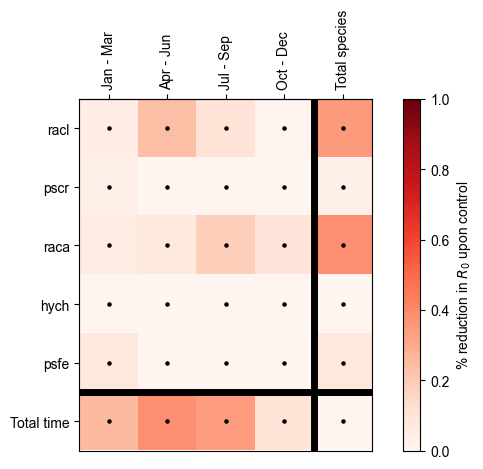

7
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


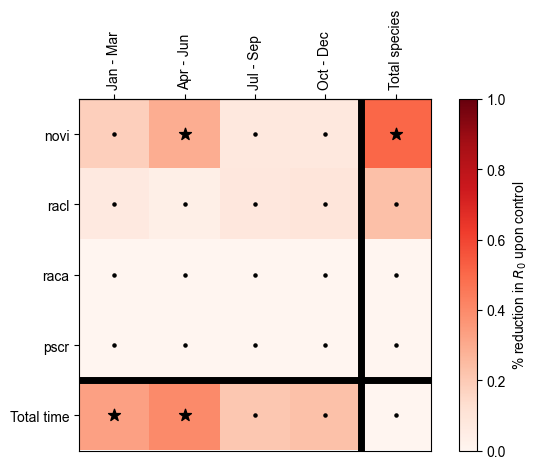

10
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


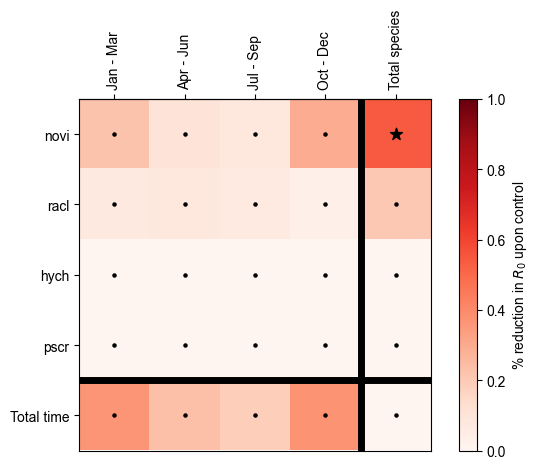

15
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(5, 0)
(5, 1)
(5, 2)
(5, 3)


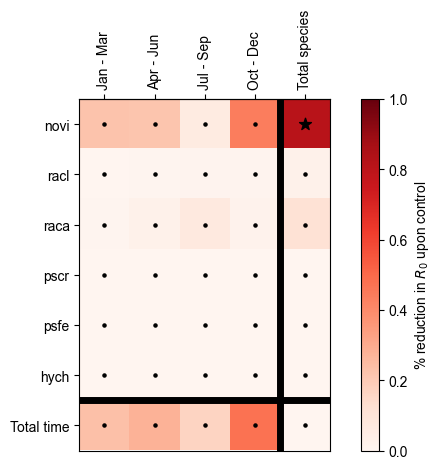

In [92]:
microhabitat = True
constant_density = False
constant_water = False
constant_intensity = False
constant_prev = False
surface_area = True

# Vary omega
omega_vals = [0.5] #[1.0, 0.25, 0.1]

for h, omega in enumerate(omega_vals):
    
    removal_results = []
    
    for site in [2, 7, 10, 15]:

        print(site)
        R, jd, S, T, species = pd.read_pickle("../results/R_matrix_site={0}_microhabitat={1}_surface_area={2}_constant_density={3}_constant_water={4}_constant_intensity={5}_constant_prev={6}_omega={7}.pkl".format(site, microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))

        R0_base = np.max(np.abs(np.linalg.eigvals(R)))
        year_length = np.int64(len(jd) / S)
        tjd = jd[:year_length][:-1]
        tjd_indexes = np.arange(len(tjd))
        # Total number of entries in array
        n = S*T

        # Time splits into four approximately equally spaced seasons
        intervals = [(x[0], x[-1]) for x in np.array_split(tjd_indexes, 4)]

        dropped_species = []
        dropped_time = []
        dropped_species_by_time = np.empty((S, len(intervals)))

        # Loop through species
        for s in range(S):

            # Drop the s species for all times
            newR = np.copy(R)
            newR[s:n:S, :] = 0
            dropped_species.append(np.max(np.abs(np.linalg.eigvals(newR))))

            # Loop through time
            for t in range(len(intervals)):

                print((s, t))
                # Drop the time for all species 
                if s == 0:
                    newR = np.copy(R)
                    start = intervals[t][0]
                    end = intervals[t][1]
                    newR[start*S:(end + 1)*S, :] = 0
                    dropped_time.append(np.max(np.abs(np.linalg.eigvals(newR))))

                # Drop a specific species by time interval
                newR = np.copy(R)
                start = intervals[t][0]
                end = intervals[t][1]
                newR[(start*S + s):(end + 1)*S:S, :] = 0 # Check this...looks good
                dropped_species_by_time[s, t] = np.max(np.abs(np.linalg.eigvals(newR)))

        d1 = np.hstack([dropped_species_by_time, np.array(dropped_species)[:, np.newaxis]])
        d2 = np.vstack([d1, np.r_[np.array(dropped_time), R0_base]])

        removal_results.append((d2, R0_base, species, site))

        # Make some plots
        fig, ax = plt.subplots(1, 1)
        cb = plt.imshow(1 - d2 / R0_base, cmap="Reds", vmin=0, vmax=1)
        cbar = plt.colorbar(cb, label="% reduction in $R_0$ upon control")
        ax.set_yticks(np.arange(len(species) + 1))
        ax.set_yticklabels(species + ['Total time'])

        secax = ax.secondary_xaxis('top')
        secax.set_xticks(np.arange(len(intervals) + 1))
        secax.set_xticklabels(['Jan - Mar', 'Apr - Jun', 'Jul - Sep', 'Oct - Dec', 'Total species'], rotation=90)

        ax.tick_params(axis="x", labelbottom=None, bottom=None)
        ax.hlines(len(species) - 0.5, -0.5, len(intervals) + 0.5, color='black', linewidth=5)
        ax.vlines(len(intervals) - 0.5, -0.5, len(species) + 0.5, color='black', linewidth=5)

        #ax.grid()
        Y, X = np.indices(d2.shape)
        x = X.ravel()
        y = Y.ravel()

        ind_greater = d2.ravel() > 1
        ind_less = d2.ravel() < 1

        if np.sum(ind_greater) >= 1:
            ax.scatter(x[ind_greater], y[ind_greater], marker='o', c='black', s=5)

        if np.sum(ind_less) >= 1:
            ax.scatter(x[ind_less], y[ind_less], marker='*', c='black', s=80)

        plt.tight_layout()
        plt.show()

        fig.savefig("../results/removal_site_{0}_omega={1}.pdf".format(site, omega), bbox_inches="tight")

    # Save control results
    pd.to_pickle(removal_results, "../results/all_removal_results_omega={0}.pkl".format(omega))

### Species controls

In [2]:
# Load in results
omega = 1.0
removal_results = pd.read_pickle("../results/all_removal_results_omega={0}.pkl".format(omega))

all_dfs = []
for i in range(len(removal_results)):
    res = removal_results[i]
    d, tR0, spp, site = res
    spp_removal = 1 - (d / tR0)[:-1, -1]
    tdf = pd.DataFrame({'species': spp, 'R0_removal': spp_removal, 'R0_control': d[:-1, -1], 'site': site})
    all_dfs.append(tdf)

all_dfs = pd.concat(all_dfs)

all_dfs['site_name'] = all_dfs.site.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})
all_dfs['site_name'] = pd.Categorical(all_dfs.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])

all_df_sum = all_dfs.groupby("species").agg({'R0_removal': ('mean', lambda x: np.std(x) / np.sqrt(len(x)))}).reset_index()

all_df_sum.columns = ['species', "R0_mean", "R0_se"]
all_df_sum['R0_min'] = all_df_sum.R0_mean - all_df_sum.R0_se
all_df_sum['R0_max'] = all_df_sum.R0_mean + all_df_sum.R0_se

## Plot the species control results

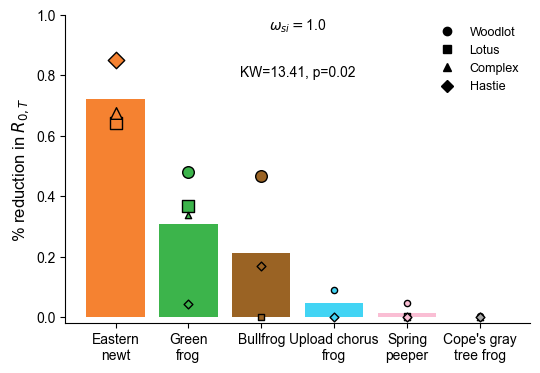

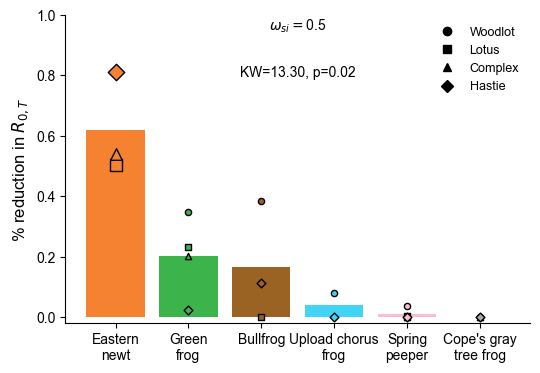

In [93]:
import scipy.stats as stats

site_by_shape = {'Woodlot': 'o', 'Lotus': 's', 'Complex': '^', 'Hastie': 'D'}

spp_map = {'hych': "Cope's gray\ntree frog", 
           'pscr': "Spring\npeeper", 
           "raca": "Bullfrog", 
           "racl": "Green\nfrog",
           "psfe": "Upload chorus\nfrog",
           "novi": "Eastern\nnewt"}

# Colors of different species
colors = {'novi': "#f58231", 
          'pscr': "#fabed4", 
          'hych': "#a9a9a9", 
          'psfe': "#42d4f4",
          'raca': "#9A6324",
          "racl": "#3cb44b"}


for omega in [1.0, 0.5]:

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=False)


    removal_results = pd.read_pickle("../results/all_removal_results_omega={0}.pkl".format(omega))

    all_dfs = []
    for i in range(len(removal_results)):
        res = removal_results[i]
        d, tR0, spp, site = res
        spp_removal = 1 - (d / tR0)[:-1, -1]
        tdf = pd.DataFrame({'species': spp, 'R0_removal': spp_removal, 'R0_control': d[:-1, -1], 'site': site})
        all_dfs.append(tdf)

    all_dfs = pd.concat(all_dfs)

    all_dfs['site_name'] = all_dfs.site.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})
    all_dfs['site_name'] = pd.Categorical(all_dfs.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])

    all_df_sum = all_dfs.groupby("species").agg({'R0_removal': ('mean', lambda x: np.std(x) / np.sqrt(len(x)))}).reset_index()

    all_df_sum.columns = ['species', "R0_mean", "R0_se"]
    all_df_sum['R0_min'] = all_df_sum.R0_mean - all_df_sum.R0_se
    all_df_sum['R0_max'] = all_df_sum.R0_mean + all_df_sum.R0_se


    all_df_sum = all_df_sum.sort_values(by="R0_mean", ascending=False)
    species = all_df_sum.species.values

    for i in range(len(species)):
        spp = species[i]
        ax.bar([i], [all_df_sum.R0_mean.values[i]], color=colors[spp])
        tdat = all_dfs.query("species == '{0}'".format(spp))
        shapes = list(tdat.site_name.map(site_by_shape).values)
        for ti, shape in enumerate(shapes):
            ax.scatter([i], [tdat.R0_removal.values[ti]], 
                       color=colors[spp], edgecolors='black', zorder=10, marker=shape, 
                       s=70 if tdat.R0_control.values[ti] < 1 else 20) #, markeredgewidth=0.1)

    #ax.errorbar(range(len(species)), all_df_sum.R0_mean, yerr=all_df_sum.R0_se, color='black', linestyle='', capsize=5)
    ax.set_xticks(range(len(species)))
    ax.set_xticklabels([spp_map[s] for s in species], rotation=0)

    # Non-parametric
    samples = [all_dfs.query("species == @spp").R0_removal.values for spp in all_dfs.species.unique()]
    kres = stats.kruskal(*samples)
    ax.text(0.5, 0.8, "KW={0:.2f}, p={1:.2f}".format(*kres), ha='center', transform=ax.transAxes)
    ax.text(0.5, 0.95, r"$\omega_{si} = $" + f"{omega}", ha='center', transform=ax.transAxes)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel("% reduction in $R_{0, T}$", fontsize=12)
    ax.set_ylim(-0.02, 1.0)

    handles = [plt.Line2D([1], [1], linestyle="", marker=shp, label=site, color='black') for site, shp in site_by_shape.items()]
    ax.legend(handles=handles, frameon=False, prop={'size': 9})
    plt.show()
    fig.savefig(f"../results/species_control_omega={omega}.pdf", bbox_inches="tight")

In [17]:
# Explore some species specific results
all_dfs.query("species == 'racl'")

,species,R0_removal,R0_control,site,site_name
0,racl,0.480914,0.868770,2,Woodlot
1,racl,0.368941,0.836711,7,Lotus
1,racl,0.338645,1.346471,10,Complex
1,racl,0.043503,4.577757,15,Hastie


## Figure S7: Plot of sampling events at each site

In [223]:
keep_sites = [2, 7, 10, 15]
survey_data = pd.read_csv("../data/survey_data.csv").query("site_id in @keep_sites")
survey_data['date'] = pd.to_datetime(survey_data.date)
survey_data['site_id'] = pd.Categorical(survey_data.site_id)
survey_data = survey_data[survey_data.date.dt.year < 2025]

# Map sites to pretty names
site_map = {2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"}
survey_data['site_name'] = survey_data.site_id.map(site_map)

/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4.5 in image.
/Users/mqwilber/opt/anaconda3/envs/recovery/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../results/sampling_times.pdf


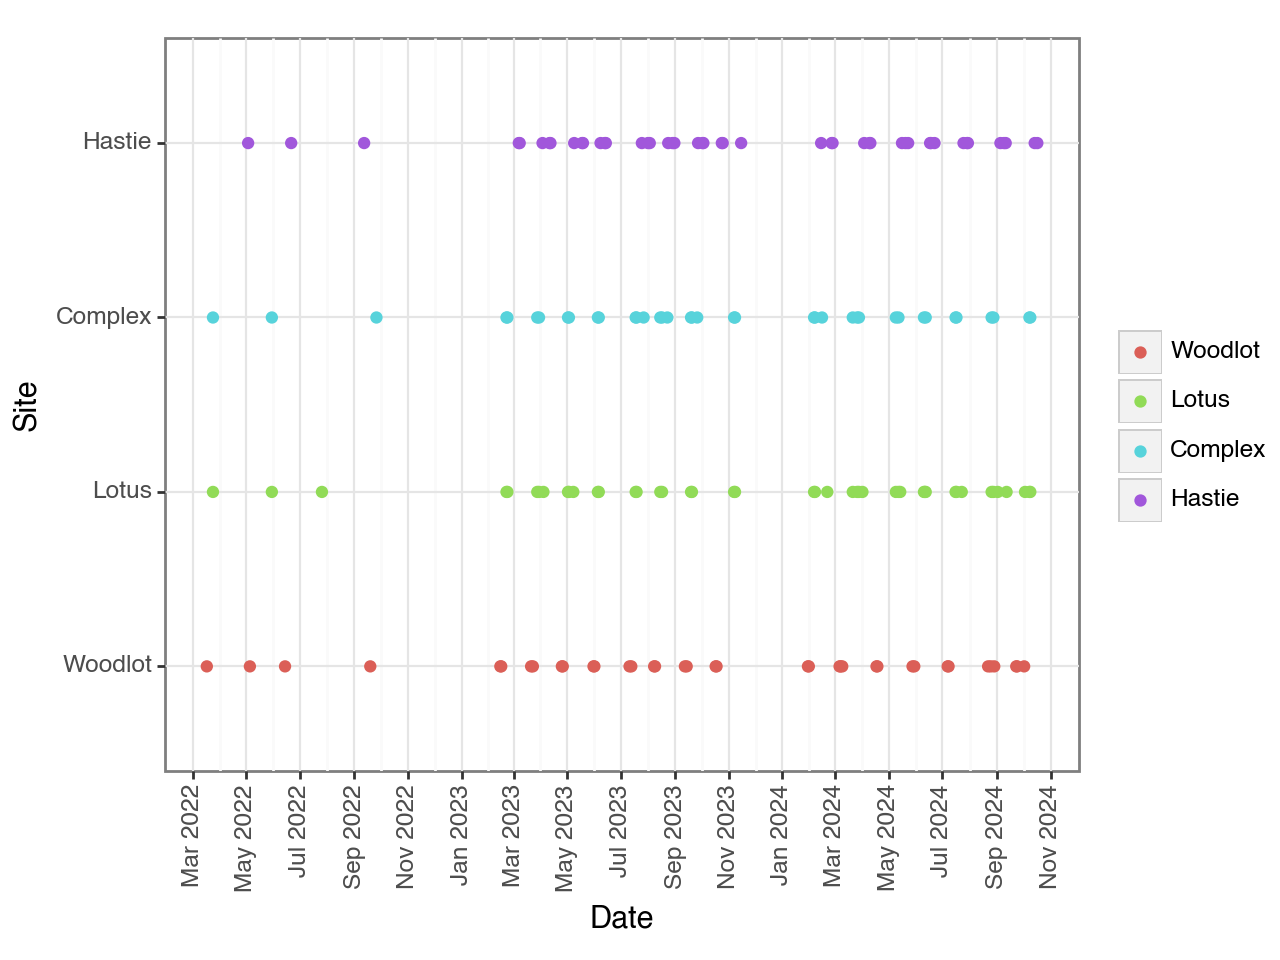

<Figure Size: (640 x 480)>

In [224]:
from plotnine import ggplot, geom_line, geom_point, aes, theme, element_text, scale_x_datetime, theme_classic, theme_bw, xlab, ylab

p = (ggplot(survey_data) + geom_point(aes(x="date", y="site_name", color="site_name")) +
                       scale_x_datetime(date_breaks="2 month", date_labels="%b %Y") +
                       xlab("Date") + ylab("Site") +
                       theme_bw() +
                       theme(axis_text_x = element_text(angle=90, vjust=1, hjust=0.2),
                             legend_title=element_text(text="")))
                                                        
p.save("../results/sampling_times.pdf", width=6, height=4.5)   
p
                                   

## Fig. S6: Plot loss of infection rates by site

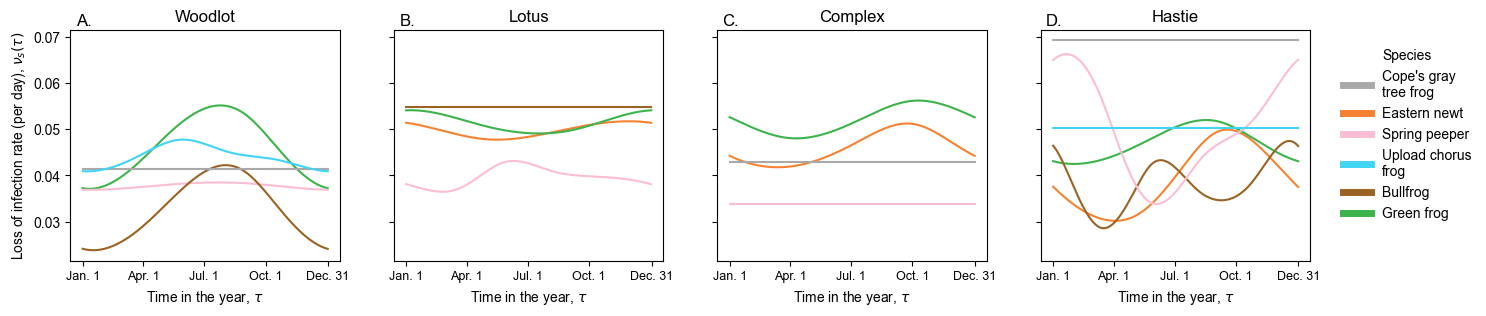

In [13]:
surface_area = True
microhabitat = True
constant_density = False
constant_intensity = False
constant_water = False
constant_prev = False
sites = [2, 7, 10, 15]
site_map = {2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"}

fig, axes = plt.subplots(1, len(sites), figsize=(16, 3), sharex=True, sharey=True)

# Colors of different species
colors = {'novi': "#f58231", 
          'pscr': "#fabed4", 
          'hych': "#a9a9a9", 
          'psfe': "#42d4f4",
          'raca': "#9A6324",
          "racl": "#3cb44b"}

spp_map = {'hych': "Cope's gray\ntree frog", 
           'pscr': "Spring peeper", 
           "raca": "Bullfrog", 
           "racl": "Green frog",
           "psfe": "Upload chorus\nfrog",
           "novi": "Eastern newt"}

for j, site_num in enumerate(sites):
    
    pred_values = pd.read_pickle("../results/all_values_{0}_results_microhabitat={1}_surface_area={2}_constant_density={3}_constant_water={4}_constant_intensity={5}_constant_prev={6}.pkl".format(site_num, microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev))
    
    species = pred_values['species']
    loss_rates = pred_values['loss_rates']
    time = pred_values['time_steps']
    axes[j].set_prop_cycle('color', [colors[s] for s in species])
    axes[j].plot(time, loss_rates.T, label=[spp_map[s] for s in species])
    axes[j].set_title(site_map[site_num])

# Format xlabels
for j in range(len(sites)):                
    axes[j].set_xticks([1, 91, 182, 273, 366])
    axes[j].set_xticklabels(["Jan. 1", 'Apr. 1', 'Jul. 1', 'Oct. 1', 'Dec. 31'], size=9)
# Add letters to all plots
letters = list(string.ascii_uppercase)
count = 0

axes[0].set_ylabel(r"Loss of infection rate (per day), $\nu_s(\tau)$")

for j in range(len(sites)):
    axes[j].text(0.05, 1.02, letters[j] + ".", size=12, ha="center", transform=axes[j].transAxes)
    axes[j].set_xlabel(r"Time in the year, $\tau$")
    
# Add a legend
ordered_spp = np.sort(list(colors.keys()))
handles = [plt.Line2D([0], [0], color=colors[s], lw=5, label=spp_map[s]) for s in ordered_spp]
axes[3].legend(handles=handles, loc=(1.1, 0.15), frameon=False, title="Species")
plt.show()
fig.savefig("../results/loss_of_infection_rates.pdf", bbox_inches="tight")

## Fig. 5: Species-specific time-integrated $R_{0, s, T}$

In [2]:
microhabitat = True
constant_density = False
constant_water = False
constant_intensity = False
constant_prev = False
surface_area = True

omega_vals = [1.0, 0.75, 0.5, 0.25, 0.1, 0.05]

all_R0_vals = []

for h, omega in enumerate(omega_vals):
    
    R0_results = []
    
    for site in [2, 7, 10, 15]:

        print(site)
        R, jd, S, T, species = pd.read_pickle("../results/R_matrix_site={0}_microhabitat={1}_surface_area={2}_constant_density={3}_constant_water={4}_constant_intensity={5}_constant_prev={6}_omega={7}.pkl".format(site, microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))

        R0_base = np.max(np.abs(np.linalg.eigvals(R)))
        year_length = np.int64(len(jd) / S)
        tjd = jd[:year_length][:-1]
        tjd_indexes = np.arange(len(tjd))
        # Total number of entries in array
        n = S*T
        species_R0_vals = []
        
        # Get species-level R0 values
        for s in range(len(species)):
            species_R0_vals.append(np.max(np.abs(np.linalg.eigvals(R[s:n:S, s:n:S]))))
        
        tR0_vals = species_R0_vals + [R0_base]
        tname = species + ['total_R0']
        R0_results.append(pd.DataFrame({'R0_value': tR0_vals, 'species': tname, 'omega': omega, 'site': site}))
    
    R0_concat = pd.concat(R0_results)
    print(R0_concat)
    all_R0_vals.append(R0_concat)

all_R0_vals_df = pd.concat(all_R0_vals)
all_R0_vals_df.to_csv("../results/species_level_R0_varying_omega.csv", index=False)

2
7
10
15
   R0_value   species  omega  site
0  0.679590      racl    1.0     2
1  0.034394      pscr    1.0     2
2  0.624990      raca    1.0     2
3  0.001213      hych    1.0     2
4  0.070265      psfe    1.0     2
5  1.673653  total_R0    1.0     2
0  0.830664      novi    1.0     7
1  0.468830      racl    1.0     7
2  0.001794      raca    1.0     7
3  0.003557      pscr    1.0     7
4  1.325884  total_R0    1.0     7
0  1.343724      novi    1.0    10
1  0.660159      racl    1.0    10
2  0.000015      hych    1.0    10
3  0.002410      pscr    1.0    10
4  2.035926  total_R0    1.0    10
0  3.716104      novi    1.0    15
1  0.175539      racl    1.0    15
2  0.540820      raca    1.0    15
3  0.000088      pscr    1.0    15
4  0.000116      psfe    1.0    15
5  0.000008      hych    1.0    15
6  4.785962  total_R0    1.0    15
2
7
10
15
   R0_value   species  omega  site
0  0.753489      racl   0.75     2
1  0.043871      pscr   0.75     2
2  0.730434      raca   0.75     2


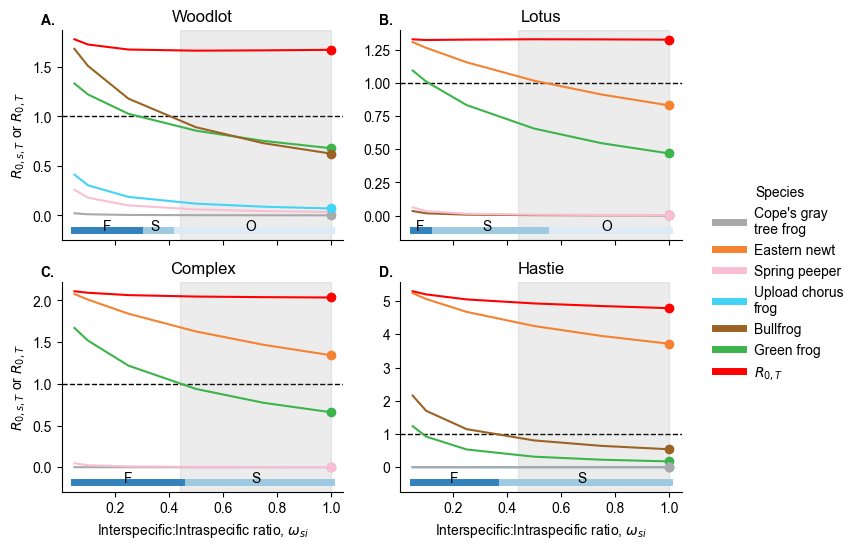

In [14]:
from scipy.interpolate import interp1d

all_R0_vals_df = pd.read_csv("../results/species_level_R0_varying_omega.csv")

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=False)
axes = axes.ravel()

# Colors of different species
colors = {'novi': "#f58231", 
          'pscr': "#fabed4", 
          'hych': "#a9a9a9", 
          'psfe': "#42d4f4",
          'raca': "#9A6324",
          "racl": "#3cb44b",
          "total_R0": 'red'}

spp_map = {'hych': "Cope's gray\ntree frog", 
           'pscr': "Spring peeper", 
           "raca": "Bullfrog", 
           "racl": "Green frog",
           "psfe": "Upload chorus\nfrog",
           "novi": "Eastern newt",
           "total_R0": r"$R_{0, T}$"}

site_map = {2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"}

val_map = {0: 'Obligate', 1: 'Spillover', 2: 'Facultative'}
val_map = {0: 'O', 1: 'S', 2: 'F'}
color_map = {0: '#deebf7', 1: '#9ecae1', 2: '#3182bd'}

unq_sites = all_R0_vals_df.site.unique()

for i, site in enumerate(unq_sites):
    
    ax = axes[i]
    
    tdf = all_R0_vals_df.query("site == {0}".format(site))
    
    unq_species = tdf.species.unique()
    
    for j, spp in enumerate(unq_species):
        
        ttdf = tdf.query("species == '{0}'".format(spp))
        
        if spp != "total_R0":
            ax.plot(ttdf.omega, ttdf.R0_value, color=colors[spp])
        else:
            ax.plot(ttdf.omega, ttdf.R0_value, color=colors[spp])
        
        tomega = ttdf.query("omega == 1.0")
        ax.plot([tomega.omega], [tomega.R0_value], 'o', color=colors[spp])
    
    
    # Create a community label
    tdf_drop = tdf.query("species != 'total_R0'")
    R0pivot = tdf_drop.pivot(columns='omega', index='species', values='R0_value')
    omega = R0pivot.columns.values
    R0mat = R0pivot.values

    vals = np.linspace(tdf.omega.min(), tdf.omega.max(), num=500)
    R0mat_interp = np.array([interp1d(omega, R0mat[i, :])(vals) for i in range(R0mat.shape[0])])

    classify = np.sum((R0mat_interp > 1), axis=0)
    classify[classify >= 2] = 2
    unq_vals = np.unique(classify)
    
    ylim = ax.get_ylim()
    for tval in unq_vals:
        tx = vals[classify == tval]
        ty = classify[classify == tval]
        ax.plot(tx, np.repeat(ylim[0] + ylim[0]*0.7, len(ty)), color=color_map[tval], lw=5)
        ax.text(np.mean(tx), ylim[0] + ylim[0]*0.7, val_map[tval], ha='center')
    
    xlim = ax.get_xlim()
    ax.hlines(1, *xlim, color='black', linestyle='dashed', zorder=-1, linewidth=1)
    ax.set_xlim(*xlim)
    ax.set_title(site_map[site])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if i in [0, 2]:
        ax.set_ylabel(r"$R_{0, s, T}$ or $R_{0, T}$")
    
    if i in [2, 3]:
        ax.set_xlabel(r"Interspecific:Intraspecific ratio, $\omega_{si}$")

ordered_spp = np.sort(list(colors.keys()))
handles = [plt.Line2D([0], [0], color=colors[s], lw=5, label=spp_map[s]) for s in ordered_spp]
axes[3].legend(handles=handles, loc=(1.1, 0.5), frameon=False, title="Species")

letters = ["A.", "B.", "C.", "D."]
for i in range(len(letters)):
    axes[i].text(-0.05, 1.025, letters[i], ha='center', transform=axes[i].transAxes, fontweight='bold')
    axes[i].axvspan(0.44, 1, color="gray", alpha=0.15)
plt.show()
fig.savefig("../results/community_types_varying_omega.pdf", bbox_inches="tight")

## Extensive temporal control for Fig. 6

In [111]:
microhabitat = True
constant_density = False
constant_water = False
constant_intensity = False
constant_prev = False
surface_area = True

omega_vals = [1.0, 0.5, 0.25]
removal_results = []

for h, omega in enumerate(omega_vals):
    
    for site in [2, 7, 10, 15]:

        print(site)
        R, jd, S, T, species = pd.read_pickle("../results/R_matrix_site={0}_microhabitat={1}_surface_area={2}_constant_density={3}_constant_water={4}_constant_intensity={5}_constant_prev={6}_omega={7}.pkl".format(site, microhabitat, surface_area, constant_density, constant_water, constant_intensity, constant_prev, omega))

        R0_base = np.max(np.abs(np.linalg.eigvals(R)))
        year_length = np.int64(len(jd) / S)
        tjd = jd[:year_length][:-1]
        dt = tjd[1] - tjd[0]
        tjd_indexes = np.arange(len(tjd))
        

        # The start and end of the time array
        first_index = 0
        last_index = len(tjd)
        
        # Set up the indices with length T, where indices within a group are 
        Rindices = np.arange(R.shape[0])
        time_index_groups = np.array_split(Rindices, T)

        # Where in the season so you want to calculcate the 90
        interval = (120.0 / 2) # The total length of a season in days. Divide by two because we move up and down from the midpoint. Update this to 120 as needed
        # How often in days in the season do you want to calculate the 90 day removals
        tstep = (30 / dt).astype(int)
        start_inds = np.arange(0, len(tjd))[0:-1:(tstep)]
        
        # Loop over temporal controls
        for tplace, start_ind in enumerate(start_inds):
            print("{0} of {1}".format(tplace + 1, len(start_inds)))

            step_indices = np.floor(interval / dt).astype(int) # Linking the interval to number of indices
            ind_end = start_ind + step_indices
            ind_begin = start_ind - step_indices

            # Wrap the indices appropriately
            if ind_begin < first_index:
                vals1 = np.arange(last_index + ind_begin, last_index, step=1)
                vals2 = np.arange(first_index, ind_end, step=1)
                time_indices = np.concatenate([vals1, vals2])
            elif ind_end > last_index:
                vals1 = np.arange(ind_begin, last_index, step=1)
                vals2 = np.arange(first_index, ind_end - last_index, step=1)
                time_indices = np.concatenate([vals1, vals2])
            else:
                time_indices = np.arange(ind_begin, ind_end, step=1)

            # Specify the indices to "control" in the R matrix
            relevant_time_indices = np.concatenate([time_index_groups[t] for t in time_indices])

            newR = np.copy(R)
            newR[relevant_time_indices, :] = 0 # No infections are produced in these time periods
            # newR[:, relevant_time_indices] = 0 # No infections are gained
            R0_control = np.max(np.abs(np.linalg.eigvals(newR)))
            removal_results.append((site, tjd[start_ind], R0_base, R0_control, interval*2, omega))
            
tres = pd.DataFrame(removal_results, columns=['site', 'time', 'R0_base', 'R0_control', 'interval', 'omega'])
tres.to_csv(f"../results/temporal_control_results_interval={interval*2}.csv", index=False)

2
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
7
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
10
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
15
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
2
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
7
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
10
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
15
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
2
1 of 13
2 of 13
3 of 13
4 of 13
5 of 13
6 of 13
7 of 13
8 of 13
9 of 13
10 of 13
11 of 13
12 of 13
13 of 13
7
1 of

In [120]:
interval = 45.0 # This is a 90-day interval: 45 * 2.  Change to 60 for a 120 day interval
tres = pd.read_csv(f"../results/temporal_control_results_interval={interval*2}.csv")

In [121]:
tres['R0_change'] = 1 - tres.R0_control / tres.R0_base
#tres.groupby(["site", "omega"]).agg({'R0_change': np.mean})

# Look at some particular values
tres.query("omega == 1.0").R0_change.min()
tres.query("omega == 1.0").R0_change.max()
tres.query("omega == 1.0 and site == 2").R0_change.max()

0.4341201697570434

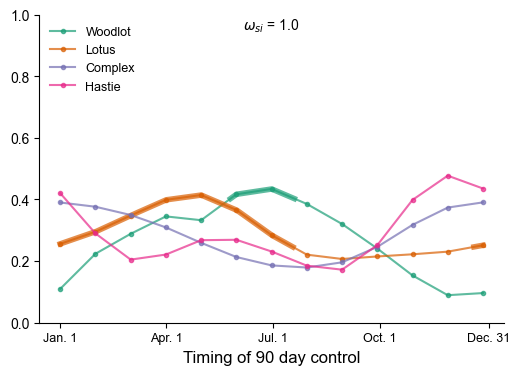

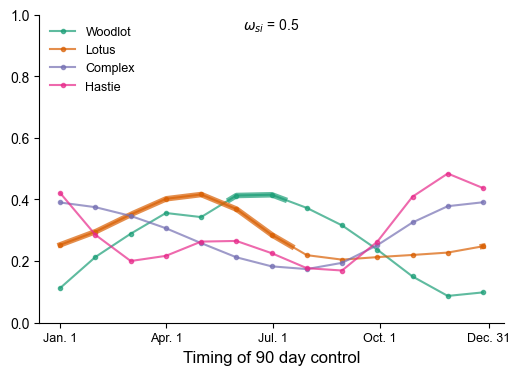

In [122]:
from scipy.interpolate import interp1d

ls = ['-', '-']
site_map = {2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"}
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']

unq_sites = tres.site.unique()

temporal_mean = tres.groupby(['omega', 'time']).agg({'R0_change': 'mean'}).reset_index()

for j, omega in enumerate([1.0, 0.5]):

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)
    
    tm = temporal_mean.query(f"omega == {omega}")
    #ax.plot(tm.time, tm.R0_change, color='black', lw=2, zorder=10, ls="dashed", label="Mean")

    # Loop over sites
    for i, site in enumerate(unq_sites):

        td = tres.query("site == {0}".format(site))

        ttd = td.query(f"omega == {omega}")

        ax.plot(ttd.time, 1 - (ttd.R0_control / ttd.R0_base), linestyle=ls[j], marker='o', markersize=3, label=f"{site_map[site]}", color=colors[i], alpha=0.7)

        fxn = interp1d(ttd.time, ttd.R0_control)
        vals = np.linspace(ttd.time.min(), ttd.time.max(), num=1500)
        y = fxn(vals)
        less_ind = y < 1

        if np.sum(less_ind) > 0:
            
            tvals = vals[less_ind]
            ty = y[less_ind]
            ax.plot(tvals[tvals < 300], 1 - (ty[tvals < 300] / ttd.R0_base.unique()), '-', lw=4, color=colors[i], alpha=0.7)
            ax.plot(tvals[tvals >= 300], 1 - (ty[tvals >= 300] / ttd.R0_base.unique()), '-', lw=4, color=colors[i], alpha=0.7)


        xlim = ax.get_xlim()
        #axes[i].hlines(1, *xlim, color='black', linestyle='--')
        #axes[i].hlines(td.R0_base.unique()[0], *xlim, color='red')
        ax.set_xlim(*xlim)
        #ax.set_title(site_map[site])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


    #ax.set_ylabel(r"% reduction in $R_{0, T}$", size=12)
    ax.set_xlabel(f"Timing of {interval*2:.0f} day control", size=12)
    ax.legend(loc="upper left", prop={'size': 9}, frameon=False)


    ax.set_xticks([1, 91, 182, 273, 366])
    ax.set_xticklabels(["Jan. 1", 'Apr. 1', 'Jul. 1', 'Oct. 1', 'Dec. 31'], size=9)
    ax.set_ylim(0, 1.0)
    ax.text(0.5, 0.95, r"$ω_{si}$ = " + f"{omega}", ha='center', transform=ax.transAxes)
    plt.show()
    
    fig.savefig(f"../results/temporal_control_omega={omega}_interval={interval*2}.pdf", bbox_inches="tight")

# Plot maximum species removal vs. maximum temporal removal

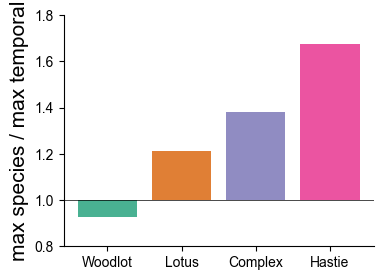

In [129]:
omega = 0.5

removal_results = pd.read_pickle("../results/all_removal_results_omega={0}.pkl".format(omega))

all_dfs = []
for i in range(len(removal_results)):
    res = removal_results[i]
    d, tR0, spp, site = res
    spp_removal = 1 - (d / tR0)[:-1, -1]
    tdf = pd.DataFrame({'species': spp, 'R0_removal': spp_removal, 'R0_control': d[:-1, -1], 'site': site})
    all_dfs.append(tdf)

all_dfs = pd.concat(all_dfs)

all_dfs['site_name'] = all_dfs.site.map({2: 'Woodlot', 7: 'Lotus', 10: 'Complex', 15: "Hastie"})
all_dfs['site_name'] = pd.Categorical(all_dfs.site_name, categories=['Woodlot', 'Lotus', 'Complex', 'Hastie'])

all_df_sum = all_dfs.groupby("species").agg({'R0_removal': ('mean', lambda x: np.std(x) / np.sqrt(len(x)))}).reset_index()

all_df_sum.columns = ['species', "R0_mean", "R0_se"]
all_df_sum['R0_min'] = all_df_sum.R0_mean - all_df_sum.R0_se
all_df_sum['R0_max'] = all_df_sum.R0_mean + all_df_sum.R0_se


all_df_sum = all_df_sum.sort_values(by="R0_mean", ascending=False)
species = all_df_sum.species.values

# Get the maximum removals by site
max_spp_removals = all_dfs.groupby("site_name").agg({'R0_removal': np.max}).reset_index()
max_spp_removals = max_spp_removals.rename(columns={'R0_removal': 'R0_change'})

max_time_removals = tres.query(f"omega == {omega}").groupby("site").agg({'R0_change': np.max}).reset_index()
max_time_removals['site_name'] = max_time_removals.site.map(site_map)
max_time_removals['R0_change_spp'] = max_spp_removals.R0_change

max_time_removals['R0_ratio']= max_time_removals.R0_change_spp.values / max_time_removals.R0_change.values

# Make a pretty boxplot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.bar(max_time_removals.site_name, max_time_removals.R0_ratio - 1, color=colors, alpha=0.8)
ax.set_ylim(-0.2, 0.8)
ax.set_yticks(np.linspace(-0.2, 0.8, num=6))
yticks = ax.get_yticks()
_ = ax.set_yticklabels(np.round(np.array(yticks) + 1, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("max species / max temporal", size=15)
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color='black', lw=0.5)
ax.set_xlim(*xlim)

fig.savefig("../results/compare_removal_omega={0}_interval={1}.pdf".format(omega, interval*2), bbox_inches="tight")